In [10]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling
import numpy as np
import pandas as pd
from sklearn.cluster import k_means, kmeans_plusplus, KMeans
from sklearn.decomposition import PCA
import math
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch

# Assignment 3 - Clustering

For this assignment you'll need to use some clustering knowledge to build a function that can generate handwritten numbers from a provided number. 

The modelling parts of this assignment are not very complex, the application of the clustering algorithms is very similar to the examples from class. This will require a little more manipulation of data, and building a little bit of structure around the models, that's where some of the challenge lies. 

## Requirements
<ul>
<li>Use clustering to take the X data (the features/pixels) of the MNIST dataset, and group it into clusters. 
    <ul>
    <li> Do not use the targets from the dataset at all. 
    <li> Use as many clusters as you think is appropriate.
    </ul>
<li>Assign labels to your clusters, so there is now a label for each cluster. You'll need to manually do a little mapping here by eye. 
<li><b>So, to this point. You take the images, ditch their labels, and do clustering to group them. You don't know which cluster is which digit. You have to then label them, or look at each one and say, "looks like 7s", then assign that group a label of 7. </b>
<li>Use GMM to build a function that can generate a new digit from the information in the cluster. 
<li>Write a function, writeNumber, that can take in an integer (you can assume it is between 1 and 20 digits, this is mostly for printing purposes, the modelling part isn't impacted by this at all) and print out that integer as a generated handwritten number. 
<li><b>When generating the handwritten numbers, each version of a digit should be different. I.e. If the number printed is 22222, there should not be 5 identical 2s, they should vary a bit like real writing. Each digit should be a new generation of data.</b>
</ul>

## Deliverables
Submit your .ipynb file to the Moodle dropbox. PLEASE make sure that the file runs BY ITSELF outside of importing libraries. It should not reference any other files, either data or code. 

Within your file, create a function called writeNumber, which takes a number as an input, and prints it out as a series of handwritten digits. The function should be callable like this, if I wanted to print the number 218201

~~~
writeNumber(218201)
~~~

This would produce something that looks, somewhat, like this:

![Writing Example](example.png "Writing Example" )

The exact appearance of the generated writing can vary, it likely won't be as well defined as this picture. As long as I can read it as a number, it is fine. 

Hint: the number of clusters may vary. 

## Grading
<ul>
<li> 70% - Code works. This is mostly a yes/no thing, if it doesn't work I'll try to see if it was a small or large issue in the code, but it largely works or it doesn't. 
<li> 20% - Numbers appearance. Is the writing OK? I'm not going to be overly picky, if they are reasonably legible, that is fine. 
<li> 10% - Code legibility. Is a quick read over of the code clear? Sections, comments, etc... 
</ul>

## Load Data
<b> Please do not change this (substantially), probably outside of choosing between the full data and a subset. Don't load the target. </b>

Note: testing will be much faster with a subset of records. 

In [501]:
#Load Data
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
X = mnist["data"][0:15000]
#X = mnist["data"]
print(X.shape)

(15000, 784)


## Cluster 

We need to break the data into clusters first... 

In [779]:
#Look at an image
def showDigit(digit, label, size=28):
    some_digit = digit
    #turn array into the correct shape
    some_digit_image = np.array(some_digit).reshape(size, size)
    #imshow displays an array like an image
    plt.imshow(some_digit_image, cmap=mpl.cm.binary)
    plt.title(label)
    plt.axis("off")
    plt.show()

#Display multiple digits
def showDigits(digits, size=28):
    #Make a grid that is the right size
    pics = len(digits)
    fig, axes = plt.subplots(1, pics, figsize=(14,6))
    plt.axis("off")

    #loop through the list of indexes, grab images and labels, plot in the "next" spot. 
    for i in range(pics):
        some_digit = digits.iloc[i]
        some_digit_image = np.array(some_digit).reshape(size, size)
        ax = axes[i]
        ax.axis("off")
        ax.imshow(some_digit_image, cmap=mpl.cm.binary)
    plt.tight_layout()
    plt.axis("off")
    plt.show()

In [76]:
#Do some feature reduction to speed up clustering model
pca = PCA(0.99, whiten=True)
pcax = pca.fit_transform(X)
pcax.shape

(15000, 328)

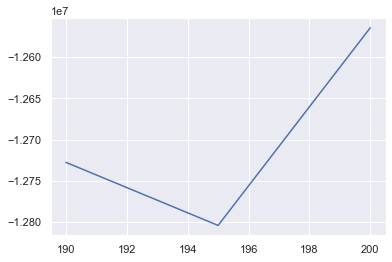

In [507]:
#identifing the optimal number of components for gmm
n_components = np.arange(190, 205, 5)
models = [GaussianMixture(n, covariance_type='full', random_state=0)
         for n in n_components]
aics = [model.fit(pcax).aic(pcax) for model in models]
plt.plot(n_components, aics)

### Model Creation and Label Prediction

In [508]:
#creating the model and predicting the clusters
gmm = GaussianMixture(195, covariance_type='full')
gmm.fit(pcax)
labels = gmm.predict(pcax)
print(gmm.converged_)

True


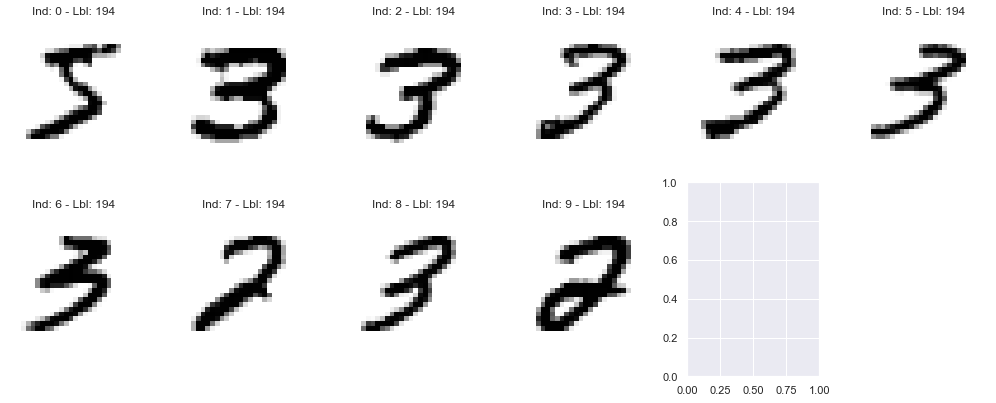

In [755]:
#display images of a particular cluster label
element = np.where(labels==194)
#X.iloc[list(element[0][0:10])]
showDigits(X.iloc[list(element[0][0:10])],labels[list(element[0][0:10])])

In [756]:
#manual assignment of cluster labels
ones = [2,6,7,10,13,19,24,26,27,33,42,46,51,55,102,118,144,151,184,186]
twos = [1,11,36,52,58,84,91,100,104,109,110,112,115,123,124,133,158,164,165,168,173,188,189]
threes = [30,39,64,69,70,76,77,88,113,120,125,146,147,154,169,171,174,183,194]
fours = [0,15,59,62,71,75,87,101,116,122,132,136,180,190]
fives = [23,50,56,83,85,89,95,121,126,127,166,178,182]
sixes = [5,14,29,32,35,41,48,49,57,74,79,82,114,128,129,135,137,138,141,145,148,155,157,167,175,191,193]
sevens = [8,12,17,18,20,28,40,43,45,60,68,72,73,81,90,93,106,107,111,130,131,140,143,150,152,156,160,163,172,177,181,192]
eights = [4,22,37,38,44,53,80,149,153,161,170,176]
nines = [16,25,31,47,54,61,63,65,66,78,86,94,96,103,108,117,119,139,142,162,187]
zeroes = [3,9,21,34,67,92,97,98,99,105,134,159,179,185]
numLabels = [ones,twos,threes,fours,fives,sixes,sevens,eights,nines,zeroes]

#making sure I didn't miss any
print(len(ones)+len(twos)+len(threes)+len(fours)+len(fives)+len(sixes)+len(sevens)+len(eights)+len(nines)+len(zeroes))

195


In [757]:
#creating a parallel array of the actual cluster labels
#why is match case only in python 3.10!?
clusterLabels = []
for i in labels:
    if i in ones:
        clusterLabels.append("1")
    elif i in twos:
        clusterLabels.append("2")
    elif i in threes:
        clusterLabels.append("3")
    elif i in fours:
        clusterLabels.append("4")
    elif i in fives:
        clusterLabels.append("5")
    elif i in sixes:
        clusterLabels.append("6")
    elif i in sevens:
        clusterLabels.append("7")
    elif i in eights:
        clusterLabels.append("8")
    elif i in nines:
        clusterLabels.append("9")
    elif i in zeroes:
        clusterLabels.append("0")


In [758]:
PCAx = pd.DataFrame(pcax)
PCAx['label'] = pd.Series(clusterLabels)
PCAx

,0,1,2,3,4,5,6,7,8,9,...,319,320,321,322,323,324,325,326,327,label
0,0.175973,-0.658436,-0.083468,-1.229670,-0.132142,-0.713115,0.647069,0.225526,-1.307962,-0.561862,...,1.475795,-0.486883,0.972102,-0.615200,0.763134,2.484532,0.275596,1.104891,-0.278595,3
1,1.743081,-0.840572,0.927734,-0.723049,-2.216020,-0.435602,-0.136384,-0.358638,0.187175,-0.565035,...,-1.258524,-0.594574,-1.899380,-0.579961,-1.107359,-1.501877,1.052580,-1.159550,-0.462702,0
2,-0.106751,0.856518,-0.608445,1.102344,-0.677130,0.329249,-2.577343,1.160718,-0.459258,0.824167,...,-2.079872,1.957477,0.198322,0.234410,1.355009,1.997452,-0.847912,-0.830802,-2.647726,7
3,-1.469280,-1.203262,0.501453,0.287746,-0.077872,1.793652,-1.028157,-0.134732,1.144584,0.149388,...,0.022398,-1.344601,-0.446137,-0.014755,-0.099773,0.026121,-1.138091,-0.521360,-0.040454,1
4,-0.575731,1.460513,0.241628,-0.575338,0.225379,0.000698,-0.370717,-1.050895,0.945736,-0.741312,...,-0.401292,-0.549618,-0.566998,-1.759183,0.891341,-0.352540,-0.467855,0.509320,-0.278243,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,-1.721108,-0.963322,0.209284,0.381090,-0.598483,0.591355,0.494008,-0.365146,0.700676,0.473512,...,-0.007880,-0.491440,0.093326,-0.314783,-0.139908,0.098157,-0.489760,-0.667835,-0.033965,1
14996,-1.084345,-0.508812,-1.256418,0.956620,0.430325,0.916753,1.210304,-0.151095,-0.074103,-0.211749,...,-1.019185,-0.283277,-1.111604,-0.575489,-1.209714,-1.687370,0.141026,0.977038,-2.434779,4
14997,-0.560067,1.335239,0.023809,-1.138306,-0.462386,-0.621312,0.048529,-0.400343,-0.727433,-0.347452,...,0.656714,-0.136709,0.023127,0.070555,0.358334,0.657792,-0.318467,-0.700472,-0.099448,9
14998,-1.382332,-0.458590,-0.258204,0.154268,-0.502646,-1.355896,0.896712,-0.540650,-0.204269,-1.562215,...,1.127802,-0.347486,0.962372,0.412487,-1.135228,0.341656,-0.334898,-0.361370,-0.659665,1


### Generating New Numbers

In [806]:
#dividing out the data into exclusive groups
oneData = PCAx[PCAx['label'] == '1']
twoData = PCAx[PCAx['label'] == '2']
threeData = PCAx[PCAx['label'] == '3']
fourData = PCAx[PCAx['label'] == '4']
fiveData = PCAx[PCAx['label'] == '5']
sixData = PCAx[PCAx['label'] == '6']
sevenData = PCAx[PCAx['label'] == '7']
eightData = PCAx[PCAx['label'] == '8']
nineData = PCAx[PCAx['label'] == '9']
zeroData = PCAx[PCAx['label'] == '0']

### Handwritten Ones

c:\Users\atrsy\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(
c:\Users\atrsy\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(
c:\Users\atrsy\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(
c:\Users\atrsy\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Window

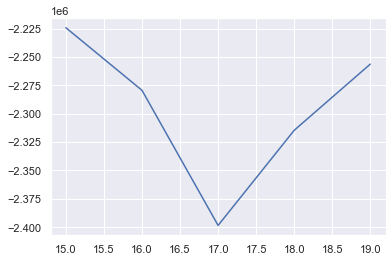

In [807]:
#identifing the optimal number of components for gmm
n_components = np.arange(15, 20)
models = [GaussianMixture(n, covariance_type='full', random_state=0)
         for n in n_components]
aics = [model.fit(oneData.drop(columns=['label'])).aic(oneData.drop(columns=['label'])) for model in models]
plt.plot(n_components, aics)

In [808]:
gmm1 = GaussianMixture(17, covariance_type='full')
gmm1.fit(oneData.drop(columns=['label']))
print(gmm.converged_)

c:\Users\atrsy\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(


True


### Handwritten Twos

c:\Users\atrsy\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Users\atrsy\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Users\atrsy\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Users\atrsy\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Window

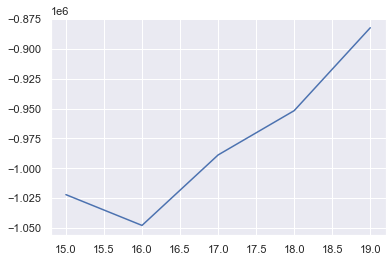

In [809]:
#identifing the optimal number of components for gmm
n_components = np.arange(15, 20)
models = [GaussianMixture(n, covariance_type='full', random_state=0)
         for n in n_components]
aics = [model.fit(twoData.drop(columns=['label'])).aic(twoData.drop(columns=['label'])) for model in models]
plt.plot(n_components, aics)

In [810]:
gmm2 = GaussianMixture(16, covariance_type='full')
gmm2.fit(twoData.drop(columns=['label']))
print(gmm.converged_)

c:\Users\atrsy\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


True


### Handwritten Threes

c:\Users\atrsy\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(
c:\Users\atrsy\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(
c:\Users\atrsy\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(
c:\Users\atrsy\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Window

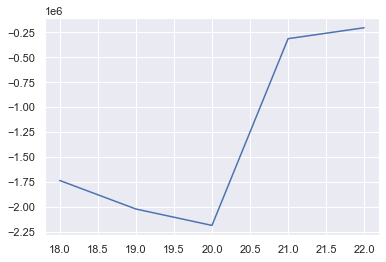

In [811]:
#identifing the optimal number of components for gmm
n_components = np.arange(18, 23)
models = [GaussianMixture(n, covariance_type='full', random_state=0)
         for n in n_components]
aics = [model.fit(threeData.drop(columns=['label'])).aic(threeData.drop(columns=['label'])) for model in models]
plt.plot(n_components, aics)

In [812]:
gmm3 = GaussianMixture(20, covariance_type='full')
gmm3.fit(threeData.drop(columns=['label']))
print(gmm.converged_)

c:\Users\atrsy\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(


True


### Handwritten Fours

c:\Users\atrsy\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
c:\Users\atrsy\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
c:\Users\atrsy\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
c:\Users\atrsy\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Window

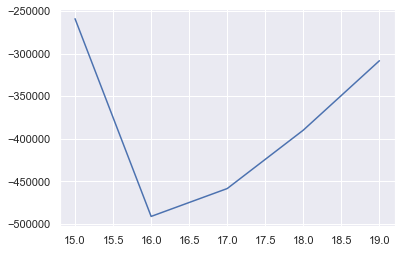

In [813]:
#identifing the optimal number of components for gmm
n_components = np.arange(15, 20)
models = [GaussianMixture(n, covariance_type='full', random_state=0)
         for n in n_components]
aics = [model.fit(fourData.drop(columns=['label'])).aic(fourData.drop(columns=['label'])) for model in models]
plt.plot(n_components, aics)

In [814]:
gmm4 = GaussianMixture(16, covariance_type='full')
gmm4.fit(fourData.drop(columns=['label']))
print(gmm.converged_)

c:\Users\atrsy\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(


True


### Handwritten Fives

c:\Users\atrsy\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Users\atrsy\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Users\atrsy\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Users\atrsy\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Window

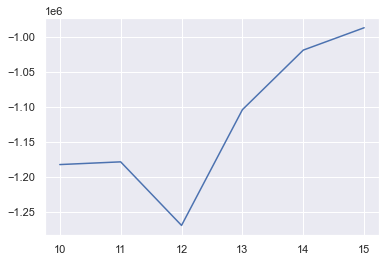

In [815]:
#identifing the optimal number of components for gmm
n_components = np.arange(10, 16)
models = [GaussianMixture(n, covariance_type='full', random_state=0)
         for n in n_components]
aics = [model.fit(fiveData.drop(columns=['label'])).aic(fiveData.drop(columns=['label'])) for model in models]
plt.plot(n_components, aics)

In [816]:
gmm5 = GaussianMixture(12, covariance_type='full')
gmm5.fit(fiveData.drop(columns=['label']))
print(gmm.converged_)

c:\Users\atrsy\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


True


### Handwritten Sixes

c:\Users\atrsy\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  warnings.warn(
c:\Users\atrsy\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  warnings.warn(
c:\Users\atrsy\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  warnings.warn(
c:\Users\atrsy\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Window

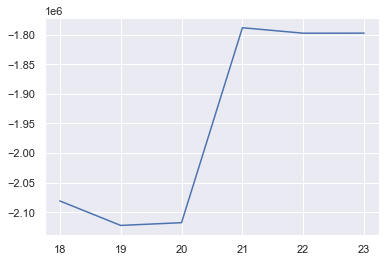

In [817]:
#identifing the optimal number of components for gmm
n_components = np.arange(18, 24)
models = [GaussianMixture(n, covariance_type='full', random_state=0)
         for n in n_components]
aics = [model.fit(sixData.drop(columns=['label'])).aic(sixData.drop(columns=['label'])) for model in models]
plt.plot(n_components, aics)

In [818]:
gmm6 = GaussianMixture(19, covariance_type='full')
gmm6.fit(sixData.drop(columns=['label']))
print(gmm.converged_)

c:\Users\atrsy\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  warnings.warn(


True


### Handwritten Sevens

c:\Users\atrsy\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
c:\Users\atrsy\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
c:\Users\atrsy\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
c:\Users\atrsy\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Window

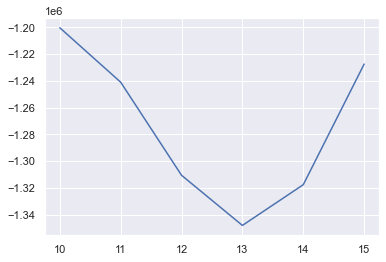

In [819]:
#identifing the optimal number of components for gmm
n_components = np.arange(10, 16)
models = [GaussianMixture(n, covariance_type='full', random_state=0)
         for n in n_components]
aics = [model.fit(sevenData.drop(columns=['label'])).aic(sevenData.drop(columns=['label'])) for model in models]
plt.plot(n_components, aics)

In [820]:
gmm7 = GaussianMixture(13, covariance_type='full')
gmm7.fit(sevenData.drop(columns=['label']))
print(gmm.converged_)

c:\Users\atrsy\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


True


### Handwritten Eights

c:\Users\atrsy\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
c:\Users\atrsy\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
c:\Users\atrsy\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
c:\Users\atrsy\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Window

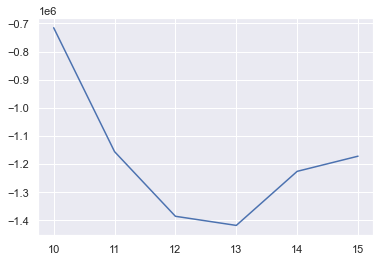

In [821]:
#identifing the optimal number of components for gmm
n_components = np.arange(10, 16)
models = [GaussianMixture(n, covariance_type='full', random_state=0)
         for n in n_components]
aics = [model.fit(eightData.drop(columns=['label'])).aic(eightData.drop(columns=['label'])) for model in models]
plt.plot(n_components, aics)

In [822]:
gmm8 = GaussianMixture(13, covariance_type='full')
gmm8.fit(eightData.drop(columns=['label']))
print(gmm.converged_)

c:\Users\atrsy\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


True


### Handwritten Nines

c:\Users\atrsy\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(
c:\Users\atrsy\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(
c:\Users\atrsy\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(
c:\Users\atrsy\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Window

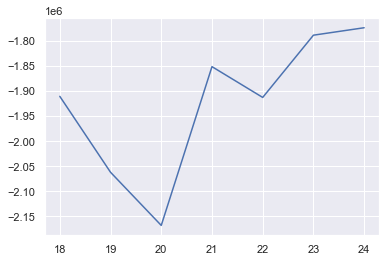

In [823]:
#identifing the optimal number of components for gmm
n_components = np.arange(18, 25)
models = [GaussianMixture(n, covariance_type='full', random_state=0)
         for n in n_components]
aics = [model.fit(nineData.drop(columns=['label'])).aic(nineData.drop(columns=['label'])) for model in models]
plt.plot(n_components, aics)

In [824]:
gmm9 = GaussianMixture(20, covariance_type='full')
gmm9.fit(nineData.drop(columns=['label']))
print(gmm.converged_)

c:\Users\atrsy\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(


True


### Handwritten Zeroes

c:\Users\atrsy\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  warnings.warn(
c:\Users\atrsy\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  warnings.warn(
c:\Users\atrsy\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  warnings.warn(
c:\Users\atrsy\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Window

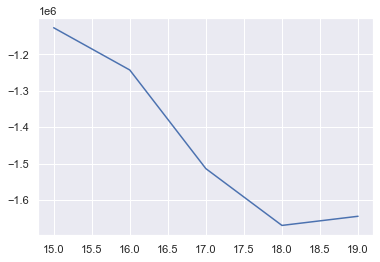

In [825]:
#identifing the optimal number of components for gmm
n_components = np.arange(15, 20)
models = [GaussianMixture(n, covariance_type='full', random_state=0)
         for n in n_components]
aics = [model.fit(zeroData.drop(columns=['label'])).aic(zeroData.drop(columns=['label'])) for model in models]
plt.plot(n_components, aics)

In [826]:
gmm0 = GaussianMixture(18, covariance_type='full')
gmm0.fit(zeroData.drop(columns=['label']))
print(gmm.converged_)

c:\Users\atrsy\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  warnings.warn(


True


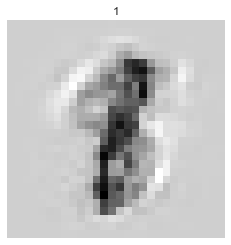

In [827]:
# testing writing generation
data_new = gmm1.sample(1)
data_new = data_new[0]
digits_new = pca.inverse_transform(data_new)
showDigit(digits_new[0],label=1)

### writeNumber

In [828]:
#takes an integer as input, and draws a handwritten version of that same number
def writeNumber(num):
    digitList = [int(i) for i in str(num)]
    numbers = []
    for i in digitList:
        if i == 1:
            data_new = gmm1.sample(1)
        elif i == 2:
            data_new = gmm2.sample(1)
        elif i == 3:
            data_new = gmm3.sample(1)
        elif i == 4:
            data_new = gmm4.sample(1)
        elif i == 5:
            data_new = gmm5.sample(1)
        elif i == 6:
            data_new = gmm6.sample(1)
        elif i == 7:
            data_new = gmm7.sample(1)
        elif i == 8:
            data_new = gmm8.sample(1)
        elif i == 9:
            data_new = gmm9.sample(1)
        elif i == 0:
            data_new = gmm0.sample(1)

        data_new = data_new[0]
        digit_new = pca.inverse_transform(data_new)
        numbers.append(digit_new[0])

    dataNumbers = pd.DataFrame(numbers)
    showDigits(dataNumbers)

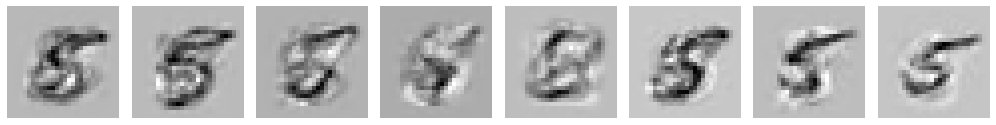

In [845]:
writeNumber(55555555)